In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc, pickle

In [4]:
###read
with open('df_merged_train.pkl', 'rb') as f:
    df_train = pickle.load(f)
    print("df_train load finished")
    
with open('df_merged_test.pkl', 'rb') as f:
    df_test = pickle.load(f)    
    print("df_test load finished")

df_train load finished
df_test load finished


In [5]:
SPLIT_POINT = 590540

df_all = pd.concat((df_train, df_test), axis=0).reset_index()

del df_train, df_test

gc.collect()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


966

In [7]:
data_null = df_all.isnull().sum()
data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)

data_null = data_null / df_all.shape[0] * 100

print("非空列有{0}个 空列占比{1}%".format(df_all.shape[1] - len(data_null), len(data_null) / df_all.shape[1] * 100))

非空列有6个 空列占比98.62068965517241%


null rate >= 70.0 的列有208个，占比总null列48.48485%


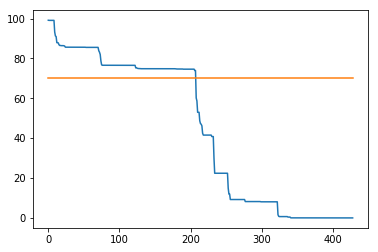

In [9]:
null_rate = 0.7 * 100

plt.plot(np.arange(data_null.shape[0]), data_null)
plt.plot(np.arange(data_null.shape[0]), np.array([null_rate] * data_null.shape[0]))

print("null rate >= {0} 的列有{1}个，占比总null列{2:.5f}%".format(null_rate, np.sum(data_null > null_rate), \
                                                     np.sum(data_null > null_rate) / data_null.shape[0]  * 100 ))

In [11]:
df_all = df_all.drop(data_null[data_null > null_rate].index, axis=1)

In [13]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097231 entries, 0 to 1097230
Columns: 227 entries, index to isFraud
dtypes: float16(187), float32(22), float64(1), int16(1), int32(2), int64(1), object(13)
memory usage: 619.5+ MB


In [14]:
def fill_numbers(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")

    for col in props.columns:
        if props[col].dtype != object:  
            
            # Print current column type
            #print("******************************")
            #print("Column: ",col)
            #print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all():  
                props[col].fillna(mn-1,inplace=True)  

    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props

df_all = fill_numbers(df_all)

Memory usage of properties dataframe is : 619.469482421875  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  619.469482421875  MB
This is  100.0 % of the initial size


In [16]:
data_null_catogory = df_all.isnull().sum()
data_null_catogory = data_null_catogory.drop(data_null_catogory[data_null_catogory == 0].index)   \
                        .sort_values(ascending=False)

data_null_catogory = data_null_catogory / df_all.shape[0] * 100

In [17]:
data_null_catogory

M5               60.161807
M7               52.977267
M9               52.974807
M8               52.974807
M4               47.318113
M3               40.806266
M2               40.806266
M1               40.806266
M6               29.920682
P_emaildomain    14.914635
card4             0.424979
card6             0.417232
dtype: float64

In [25]:
#应该还可以提高，不然others类别占比比正常值还高
use_top_email = 8

use_top_email_cols = (df_all['P_emaildomain'].value_counts(dropna=False) / \
                      df_all.shape[0] * 100)[:use_top_email]

print('top {0} email domain rank {1} %'.format(use_top_email, use_top_email_cols.sum()))

df_all['P_emaildomain'] = df_all['P_emaildomain'].apply(lambda x: \
                                                        x if x in use_top_email_cols.index else 'others')

top 8 email domain rank 92.78565771473829 %


In [24]:
use_top_email_cols

gmail.com        39.718437
yahoo.com        16.658662
NaN              14.914635
hotmail.com       7.805922
anonymous.com     6.476485
aol.com           4.769916
comcast.net       1.319139
icloud.com        1.122462
Name: P_emaildomain, dtype: float64

In [26]:
#d1 = pd.get_dummies(df_train['M1'], dummy_na=True, prefix='M1_')
#except P_emaildomain
#部分列取值范围不一样，甚至test取值比train取值更广，是以train的为准，还是全集为准
def fill_dummy_category(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    print("before, data shape {0}".format(props.shape))
    need_drop = []
    need_add = pd.DataFrame()
    for col in props.columns:
        if props[col].dtype == object:  # Exclude strings
            
            need_drop.append(col)
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            #print("dtype before: ",props[col].dtype)
            print("取值种类: {0}".format(len(props[col].value_counts(dropna=False).index)))
            
            dummy = pd.get_dummies(props[col], dummy_na=True, prefix='%s_'%col)
            
            need_add = pd.concat((need_add, dummy), axis=1)


    props = props.drop(need_drop, axis=1)
    props = pd.concat((props, need_add), axis=1)
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    print("after, data shape {0}".format(props.shape))
    return props


df_all_dy = fill_dummy_category(df_all)

del df_all
gc.collect()

Memory usage of properties dataframe is : 619.469482421875  MB
before, data shape (1097231, 227)
******************************
Column:  M1
取值种类: 3
******************************
Column:  M2
取值种类: 3
******************************
Column:  M3
取值种类: 3
******************************
Column:  M4
取值种类: 4
******************************
Column:  M5
取值种类: 3
******************************
Column:  M6
取值种类: 3
******************************
Column:  M7
取值种类: 3
******************************
Column:  M8
取值种类: 3
******************************
Column:  M9
取值种类: 3
******************************
Column:  P_emaildomain
取值种类: 9
******************************
Column:  ProductCD
取值种类: 5
******************************
Column:  card4
取值种类: 5
******************************
Column:  card6
取值种类: 5
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  566.103030204773  MB
This is  91.38513619614305 % of the initial size
after, data shape (1097231, 267)


In [28]:
#write
with open("train_test_590540.pkl", 'wb') as f:
    pickle.dump(df_all_dy, f)

In [5]:
#read
with open("train_test_590540.pkl", 'rb') as f:
    df_all_dy = pickle.load(f)

In [71]:
#显示所有列
pd.set_option('display.max_columns', None)


df_all_dy.head()

,index,C1,C10,C11,C12,C13,C14,C2,C3,C4,C5,C6,C7,C8,C9,D1,D10,D11,D15,D2,D3,D4,D5,TransactionAmt,TransactionID,V1,V10,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V11,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V12,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V13,V130,V131,V132,V133,V134,V135,V136,V137,V14,V15,V16,V17,V18,V19,V2,V20,V21,V22,V23,V24,V25,V26,V27,V279,V28,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V29,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V3,V30,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V31,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V32,V320,V321,V33,V34,V35,V36,V37,V38,V39,V4,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V5,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V6,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V7,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V8,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V9,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,addr1,addr2,card1,card2,card3,card5,dist1,isFraud,M1__F,M1__T,M1__nan,M2__F,M2__T,M2__nan,M3__F,M3__T,M3__nan,M4__M0,M4__M1,M4__M2,M4__nan,M5__F,M5__T,M5__nan,M6__F,M6__T,M6__nan,M7__F,M7__T,M7__nan,M8__F,M8__T,M8__nan,M9__F,M9__T,M9__nan,P_emaildomain__anonymous.com,P_emaildomain__aol.com,P_emaildomain__comcast.net,P_emaildomain__gmail.com,P_emaildomain__hotmail.com,P_emaildomain__icloud.com,P_emaildomain__others,P_emaildomain__yahoo.com,P_emaildomain__nan,ProductCD__C,ProductCD__H,ProductCD__R,ProductCD__S,ProductCD__W,ProductCD__nan,card4__american express,card4__discover,card4__mastercard,card4__visa,card4__nan,card6__charge card,card6__credit,card6__debit,card6__debit or credit,card6__nan,TransactionDT__0.0,TransactionDT__1.0,TransactionDT__2.0,TransactionDT__3.0,TransactionDT__nan
0,0,1.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,14.0,13.0,13.0,0.0,-1.0,13.0,-123.0,-1.0,68.5,2987000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,1.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,315.0,87.0,13926,99.0,150.0,142.0,19.0,0.0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0
1,1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-54.0,0.0,-1.0,-1.0,0.0,-1.0,29.0,2987001,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,325.0,87.0,2755,404.0,150.0,102.0,-1.0,0.0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0
2,2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,315.0,315.0,-1.0,-1.0,0.0,-1.0,59.0,2987002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [48]:
df_all_dy['TransactionDT'].describe()

count    1.097231e+06
mean     1.640384e+07
std      1.081612e+07
min      8.640000e+04
25%      6.651887e+06
50%      1.449162e+07
75%      2.651323e+07
max      3.421434e+07
Name: TransactionDT, dtype: float64

In [88]:
def handle_dt(data):
    
    data['TransactionDT'] = data['TransactionDT'].apply(lambda x:(x+59) // 60 // 60 % 24)
    
    '''
    t1 = 3.421434e+07
    t2 = 8.640000e+04

    t1-t2, 24*60*60
    
    #out 
    (34127940.0, 86400)
    '''
    
    def judge_zone(dt_hour):
        zone = [(7, 12), (12, 17), (17, 23)]# other is (23, 7)
        #ch = 3
        for idx, zn in enumerate(zone):
            if dt_hour >= zn[0] and dt_hour < zn[1]:
                return idx
        return 3
    
    data['TransactionDT'] = data['TransactionDT'].apply(lambda x:judge_zone(x))
    #print(data['TransactionDT'].describe())
    
    dummy = pd.get_dummies(data['TransactionDT'], dummy_na=True, prefix='%s_' % 'TransactionDT')
    data = data.drop(['TransactionDT'], axis=1)
    data = pd.concat((data, dummy), axis=1)
    
    return data

df_all_dy = handle_dt(df_all_dy)

In [6]:
train_label = df_all_dy['isFraud']

In [94]:
train_label[:SPLIT_POINT].describe()

count    590540.000000
mean          0.034990
std           0.183755
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: isFraud, dtype: float64

In [90]:
#scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_all_scaler = scaler.fit_transform(df_all_dy.drop(['TransactionID', 'index', 'isFraud'], axis=1))

In [91]:
#write
with open("all_590540_scaler_no_id_idx.pkl", 'wb') as f:
    pickle.dump(df_all_scaler, f)

In [80]:
df_all_scaler.mean(axis=0), df_all_scaler.std(axis=0).shape

(array([-1.18118240e-17,  1.40912989e-17,  3.73004970e-18,  3.31559973e-18,
        -3.97612936e-18,  1.91683109e-18,  2.17586232e-18,  1.46611676e-17,
         8.70344929e-18, -3.53836659e-17,  1.13973741e-18, -5.80229953e-18,
        -1.08793116e-17, -8.65164304e-18, -4.52786588e-17,  4.62111712e-17,
         3.47101847e-17, -3.74041095e-17,  5.42929456e-17, -3.30005786e-17,
        -4.60039463e-17,  2.66284103e-17,  3.34150285e-18, -1.20035071e-16,
        -1.12937616e-17,  1.76141236e-18,  7.95225873e-18,  3.47101847e-18,
        -5.43965581e-18,  4.97598991e-17,  1.81321860e-19, -6.21674949e-19,
        -1.54563934e-16, -5.37049447e-16, -1.55470544e-16, -4.89050960e-17,
         7.11766011e-16,  6.42967316e-16,  8.92103552e-16, -3.52437890e-16,
        -3.36636985e-16,  3.73160388e-16, -4.86149810e-16,  2.28188380e-15,
         8.64646242e-16,  1.00918567e-16, -2.80789852e-17,  8.61978220e-16,
        -4.21676938e-16, -1.10243691e-15,  1.84948297e-16,  2.74909843e-16,
        -2.2

In [95]:
#del df_all_dy

#gc.collect()

df_train = df_all_scaler[:SPLIT_POINT, :]
df_test  = df_all_scaler[SPLIT_POINT:, :]

In [96]:
del df_all_scaler

In [98]:
import xgboost as xgb

clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019,
    #tree_method='gpu_hist'  # THE MAGICAL PARAMETER
)

%time clf.fit(df_train, train_label[:SPLIT_POINT])

CPU times: user 1h 33min 32s, sys: 11.5 s, total: 1h 33min 43s
Wall time: 1h 33min 53s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=-999, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2019,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [99]:
#write
with open("xgb-scaler-1.pkl", 'wb') as f:
    pickle.dump(clf, f)

In [2]:
#read
with open("xgb-scaler-1.pkl", 'rb') as f:
    clf = pickle.load(f)

In [4]:
from sklearn.metrics import roc_auc_score

roc_auc_score(train_label[:SPLIT_POINT], clf.predict_proba())

TypeError: score() missing 2 required positional arguments: 'X' and 'y'

In [101]:
sample_submission = pd.read_csv('data/ieee-fraud-detection/sample_submission.csv')
sample_submission['isFraud'] = clf.predict_proba(df_test)[:,1]
sample_submission.to_csv('simple_xgboost-scaler-9-16.csv', index=False, columns=['TransactionID', 'isFraud'])

In [102]:
tmp = pd.read_csv('simple_xgboost-scaler-9-16.csv')

In [103]:
tmp

,TransactionID,isFraud
0,3663549,0.003226
1,3663550,0.001701
2,3663551,0.001030
3,3663552,0.001004
4,3663553,0.002068
5,3663554,0.002231
6,3663555,0.009807
7,3663556,0.034800
8,3663557,0.000181
9,3663558,0.007303


In [ ]:
#训练时应删除 
#index、TransactionID
#待处理
#TransactionDT
#归一化数据
#train  test split
#roc_score calculate